In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

%matplotlib inline

In [2]:
os.chdir('/Users/tian/Dropbox/erdo-bootcamp/CoverMyMed')

In [3]:
claims = pd.read_csv('pharmacy_tx.csv')

In [4]:
claims.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13910244 entries, 0 to 13910243
Data columns (total 9 columns):
 #   Column       Dtype  
---  ------       -----  
 0   tx_date      object 
 1   pharmacy     object 
 2   diagnosis    object 
 3   drug         object 
 4   bin          int64  
 5   pcn          object 
 6   group        object 
 7   rejected     bool   
 8   patient_pay  float64
dtypes: bool(1), float64(1), int64(1), object(6)
memory usage: 862.3+ MB


In [5]:
def feature_info(feature):
    descr = {'tx_date': 'The date on which the pharmacy transaction was attempted',
             'pharmacy': 'The particular pharmacy where the transaction was attempted',
             'diagnosis': 'The diagnosis of the patient associated with the transaction',
             'drug': 'The drug that the patient was prescribed that the pharmacy is attempting to bill',
             'bin': 'The broadest identifier of a patient’s insurance plan (banking identification number)',
             'pcn': 'An identifier that more narrowly specifies a plan underneath the broader "bin"',
             'group': 'Another identifier that more narrowly specifies a plan underneath the broader "bin"',
             'rejected': 'Whether the billing transaction was rejected by the plan',
             'patient_pay': 'The amount of copayment for which the patient is responsible'}
    return descr[feature]

Becuase of the memory issue, we have to drop columns further. We have agreed on keeping the features below. 

In [6]:
claims['day'] = pd.to_datetime(claims.tx_date).apply(lambda x: x.dayofyear)
claims = claims.drop(columns = ['tx_date'])
claims.head()

,pharmacy,diagnosis,drug,bin,pcn,group,rejected,patient_pay,day
0,Pharmacy #6,G99.93,branded tanoclolol,725700,1UQC,NaN,False,13.39,2
1,Pharmacy #42,U60.52,branded oxasoted,664344,NaN,52H8KH0F83K,False,7.02,2
2,Pharmacy #37,Q85.91,branded cupitelol,725700,1UQC,NaN,False,13.39,2
3,Pharmacy #30,U60.52,generic oxasoted,571569,KB38N,6BYJBW,False,10.84,2
4,Pharmacy #18,N55.01,branded mamate,664344,NaN,ZX2QUWR,False,47.00,2


In [7]:
claims['day'].max()

364

<AxesSubplot:xlabel='day'>

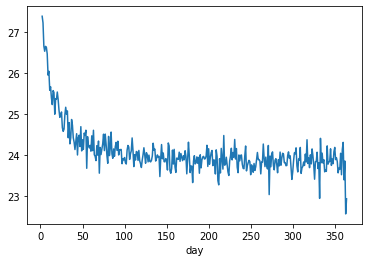

In [8]:
claims.groupby(by = 'day')['patient_pay'].mean().plot()


In [7]:
claims = claims[claims['rejected']==False]

In [8]:
claims = claims.drop(columns = ['pharmacy', 'group', 'pcn', 'rejected'])
claims['bin '] = claims['bin'].map(str)
# claims.head()

In [9]:
claims['drug_type'] = claims['drug'].apply(lambda x: x.split(' ')[0])
claims['drug'] = claims['drug'].apply(lambda x: x.split(' ')[1])
# claims.head()

In [10]:
claims = claims[['day', 'drug_type', 'drug', 'diagnosis', 'bin', 'patient_pay']]


In [11]:
X = claims.copy()
y = X.iloc[:,-1]
X = X.drop(columns = ['patient_pay'])

X['bin'] = X['bin'].map(str)

X = pd.get_dummies(X, drop_first = True)


### Models to explore

- Boosted Trees Regresstion (Adaboost)


In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error,mean_squared_error,mean_squared_log_error
from joblib import dump

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [19]:
def relu(x):
    return max(0,x)
    
def run_model_samples(model, X_train, y_train, X_test, y_test, n_samples, sample_prop):
    preds = np.zeros((n_samples, len(y_test)))
    for i in range(n_samples):
        #Get random subset
        I = np.random.choice(X_train.index, size = int(sample_prop*len(X_train)), replace = False)

        #Get sub-datasets
        X_tt, y_tt = X_train.loc[I], y_train.loc[I]
        
        # Fit Model
        model.fit(X_tt,y_tt)
    
        # Get Prediction for each sample
        preds[i] = np.array(list(map(relu,model.predict(X_test))))
            
    #Average predictions
    avg_preds = np.mean(preds, axis = 0)
    
    #Calculate KPIs of average predictions
    rmse = np.sqrt(mean_squared_error(y_test, avg_preds))
    print(f'RMSE : {rmse}')
    rmsle = mean_squared_log_error(y_test, avg_preds, squared = False)
    print(f'RMLSE: {rmsle}')

### Adaboost

In [15]:
from sklearn.ensemble import AdaBoostRegressor

In [16]:
abr_model = AdaBoostRegressor()

In [20]:
run_model_samples(abr_model,X_train,y_train,X_test,y_test,10,0.1)

RMSE : 37.81272847948041
RMLSE: 1.1312026476637838
